# Quantum Lattice Boltzmann Method


The Quantum Lattice Boltzmann Method (QLBM) brings the ideas of the classical lattice Boltzmann method into the quantum computing framework.
In this notebook, we introduce the background concepts, explain how the classical method works, and motivate why a quantum version can help overcome some of its limitations. We exemplify the algorithm by analyzing a collisionless model example is inspired by the work of Schalkers and Moller [1].

## Background
 Fluid dynamics are commonly well characterized by the famous Navier-Stokes equations - a set of non-linear coupled partial differential equations. Due to the non-linearity and multiscale nature of the dynamics, a precise solution for practical systems requires infeasible numerical resources (for further details see the technical supplementary at the bottom). 
 
Instead of working directly with the macroscopic fluid equations, one can take a microscopic viewpoint: Fluids are modeled as collections of particles and their behavior is described statistically, using the Boltzmann transport equation. A solution to the dynamics of the distribution function can be obtained by employing the (classical) Lattice Boltzmann Method (LBM).

 

## Lattice Boltzmann Method (LBM)
The Lattice Boltzmann Method simplifies the complex dynamics over the whole of phase space by replacing the velocity distribution with a discrete set of velocities, $\{\mathbf{v}_i\}$. Each lattice site $\mathbf{x}$ is characterized by a vector of distributions $f_i(\mathbf{x})$, representing the number of particles at that point with a velocity $\mathbf{v}_i$. The distributions evolve according to a discretized version of the Boltzmann transport equation.

Within the simplified description, the evolution is dictated by three distinct processes:
1. Streaming: distributions move along the velocity directions to neighboring lattice sites $$ f_i(\mathbf{x} +\mathbf{v}_{i},t +\Delta t) = f_i (\mathbf{x},t) $$.
2. Collision: distribution of each site relaxes to equilibrium $$ f_i(\mathbf{x}, t) = f_i(\mathbf{x},t) - \Gamma (f^{eq}_i(\mathbf{x},t) - f_i(\mathbf{x},t))~~,$$ where $\Gamma$ is the relaxation rate.
3. Specular Reflection: particles reaching the boundary walls or obstacles reflect off them. 

We can approximate the microscopic dynamics by repeating these steps over small time intervals. Moreover, for sufficiently small lattice spacing the results converge to the hydrodynamic variables of the Navier–Stokes equations for an incompressible isothermal fluid.
 For example, the density and velocity density can be expressed as
$$ \rho(\mathbf{x},t) = \sum_i f_i(\mathbf{x},t)~~~,~~~\rho \mathbf{u}(\mathbf{x},t) = \sum_i f_i(\mathbf{x},t) \mathbf{v}_i ~~,$$
where $\mathbf{u}$ is the (macroscopic) velocity field.

The method enables a local description that can be efficiently parallelized, incorporates complex boundary conditions, and can be extended to other dynamical problems, such as heat transport and magnetohydrodynamics.

### Challenges in the classical approach
Despite the simplification, all classical solvers face several fundamental challenges:
- The number of lattice sites required to accurately describe turbulence scales unfavorably with the Reynolds number. As a result, for realistic turbulence, the cost becomes prohibitive.
- Numerical instabilities can appear at high resolutions.
- For 3D systems of interest, the required number of lattice sites may be trillions.

The quantum Boltzmann lattice method is motivated by these challenges.
Quantum computers have the potential to bypass the scaling issues, offering potential exponential or polynomial speedups in simulating fluid dynamics.
This opens the door to study regimes that are entirely out of reach for classical solvers.

## Quantum Lattice Boltzmann Method

In the Quantum Lattice Boltzmann Method (QLBM) the distributions $\{f_i\}$ are encoded in the amplitudes $\psi_{\mathbf{x},i}(0)$ of a quantum wavefunction $
\ket{\Psi}$, while the streaming, collision and reflections are achieved by application of unitary transformations.

The algorithm is composed of three stages:
1. Initialization - the initial classical distributions and velocities are mapped to separate qubit registers. The $N$ lattice sites, and $V$ velocities are represented by the possible configurations of $\log(N)$ "positional" registers and $\log(V)$ "velocity" registers.
   $$ \ket{\Psi(0)} = \sum_{\mathbf{x},\mathbf{v}} \psi_{\mathbf{xv}}(0) \ket{\mathbf{x}} \otimes \ket{\mathbf{v}}~~.$$ 
2. Evolution - repeated operatortion of $U_{\Delta t} = U_{\text{ref}} U_{\text{str}}$ propagates the state in time $$ \ket{\Psi(t = n\Delta t)} = (U_{\Delta t})^n \ket{\Psi (0)}~~.$$ Streaming and reflections are obtained by a conditional shift operator, inducing the mapping: $\ket{\mathbf{x}}\otimes \ket{\mathbf{v}} \rightarrow \ket{\mathbf{x} + \mathbf{v}\Delta t} \otimes \ket{\mathbf{v}}$, while collision can be performed by local rotations which mix the velocity states at each site.
3. Readout - measurement in the computational basis.

Repeating the experiment many times allows us to infer statistical averages, corresponding to the macroscopic hydrodynamic variables.


## Simulation of a Collisionless Model with Classiq

As a conceptual example, we consider a collisionless model in which the particle distribution evolves according to repeated streaming and reflection operations. 

We begin by defining the encoding of the initial distribution in the quantum register

### State encoding
The set of classical states are encoded in quantum states of the form
$$\ket{ֿֿ\text{grid|velocity}}=\ket{g_x g_y| v_{\text{dir},x}  u_x v_{\text{dir},y} u_y}~~,$$  where 
the grid ($g_x$, $g_y$) and velocity magnitude ($u_x$, $u_y$) variables  are encoded as QNum variables, and the velocity directions ($v_{\text{dir},x}$, $v_{\text{dir},y}$) are encoded as standard qubits. The QNum's allow a straight forward implemintation of shift operations, while the velocity directional encoding enables flipping the direciton in the $i$'th dimension by application of a single NOT operation on $v_{\text{dir},i}$.

### Time evolution: 
The time-step is composed from two operations:
1. Streaming: particles move one lattice site if there speed allows it (descretized via CFL-based-schedule)
2. Reflection: partilces hitting the obstacle are specularly reflected—direction is flipped, and they are pushed back into the domain.

We condiser periodic boundary conditions in space, while the obstacle is placed between selected lattice sites, acting as a perfectly reflecting wall. The obstacle is placed within the lattice forming a barrier around the center of the grid.


The quantum initial part of the circuit is of the form:

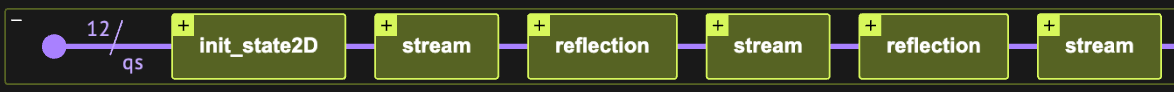

#### Initial condition
We start with a uniform velocity distribution located at a single grid point left of the obstacle.

### Observables
After running the quantum circuit, we measure the
- spatial distribution $p(x)$ - probability to find a particle at each site
- velocity distribution $p(u)$ - propability over velocity magnitudes

Next, we evaluate the scheduling function employed in the streaming and initialize the initial distribution.

In [39]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from classiq import *

### Schedulling function

A classical time-series function implements a CFL counter, tracking the velocity magnitudes streamed at each time-step. The time steps duration are set such that at each step the distributions $f_i(\mathbf{x})$ will at most transition to a neighboring lattice site. As a consequence, the durations generally vary between time-steps.

To evaluate the streamed velocities we first need to compute the time interval after the $m$'th time-steps, $\Delta t^m$. To this end, consider a distribution $f_i(\mathbf{x})$ at a time-step $m$ at position $x_m$, advancing with a speed $u_k$ away from a lattice site at $x_0$. The fraction of the distance from the lattice site in the following time-step can be expressed as $$c^{m+1}_k = \frac{x_m + |u_k| \Delta t^m -x_0}{\Delta x} = c^{m}_k + |u_k|\frac{\Delta t^m} {\Delta x}~~,$$ where $\Delta x$ is the lattice spacing.

If particles may only travel to the nearest lattice site during a single time-step, to evaluate $\Delta t^m$, we set $c^{m+1}_k = 1$, leading to
$ \Delta t^{m} = (1-c^m_k)\frac{\Delta x}{|u_k|}$.

Finally, for multiple possible velocities, the limiting time step is evaluated by minimizing over all velocity magnitudes
$$ \Delta t^{m} = \min_{k}(1-c^m_k)\frac{\Delta x}{|u_k|}~~.$$

Utilizing $\Delta t^{m}$ we can evaluate $c^{m}_k$ for all velocites and determine which distributions have reached a lattice site.


In [40]:
def time_series(
    discrete_velocities: np.ndarray,
    time: float = 10.0,
    tolerance: float = 1e-6,
    max_iters: int = 10**3,
) -> List[List[int]]:
    """
    Implements a CFL counter, evaluating the time series of streaming velocities for a discrete set of velocities

    Parameters:
        discrete_velocities: list,
        time: float, simulation time
        tolerance: float,
        max_iters: int, maximum number of propagation steps

    Returns:
        schedule: List[List[int]], each list dictates the velocities streamed at the corresponding time step.
        accumulated_time: float, total time duration of the simulation
    """

    num_discrete_velocities = discrete_velocities.shape[0]
    velocity_magnitudes = np.array(sorted(set((np.abs(discrete_velocities).tolist()))))

    # Assumes that velocity magnitudes are the same in all directions
    M = discrete_velocities.shape[0] // 2 + (discrete_velocities.shape[0] % 2)

    # Track the "progress" of each distribution towards the next grid point
    cfl_counter = np.zeros(M)
    inverse_velocities = 1 / velocity_magnitudes
    ones = np.ones(M)

    # Contains the velocities to be streamed at for each time step
    schedule: List[List[int]] = []

    # Accumulated time
    accumulated_time = 0

    #
    for _ in range(max_iters):
        # The "ground" covered by each velocity magnitude after this step
        time_intervals = np.multiply(ones - cfl_counter, inverse_velocities)

        # The minimum of time_intervals dictates which velocity limits the time step such that in the next step
        # the associated distribution will reach the next grid point
        min_time_interval = time_intervals[np.argmin(time_intervals)]

        # Update the accumulated time
        accumulated_time += min_time_interval

        # Update the progress of each velocity
        cfl_counter += min_time_interval * velocity_magnitudes

        # Get the indices of the velocities that have reached the next grid point
        streamed = np.squeeze(
            np.argwhere(np.isclose(cfl_counter, 1.0, tolerance)), axis=1
        )

        # Reset the progress of the velocities streamed at this time step
        cfl_counter[streamed] = 0.0

        # Track the controlled velocities
        schedule.append(streamed.tolist())

        n_mag_bits = int(np.ceil(np.log2(M))) if M > 1 else 1

        if accumulated_time >= time:
            break

    return schedule, accumulated_time

## Initialization

We initialize the model parameters

In [41]:
def num_bits(n):
    """Returns the number of bits required to represent n numbers"""
    return int(np.ceil(np.log2(n)))


# Grid parameters
n_g_i = 8
n_g_i_bits = num_bits(n_g_i)

# Velocities
discrete_velocities = np.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])

# Velocity magnitudes
u = np.unique(np.abs(discrete_velocities))
n_u_i = u.shape[0]
n_u_i_bits = num_bits(
    n_u_i
)  # number of bits required to represent the magnitudes in the x and y directions

The quantum register is conveniently stored within a QStruct variable. The customized object will allow simple and direct access the different registers.

In [42]:
class PhaseSpaceStruct(QStruct):
    """Wrapping class including all the quantum variables"""

    # Grid variables
    g_x: QNum[n_g_i_bits, UNSIGNED, 0]  # x-axis grid register
    g_y: QNum[n_g_i_bits, UNSIGNED, 0]  # y-axis grid register

    # Velocity directions
    v_dir_x: QBit
    v_dir_y: QBit

    # Velocity magnitudes
    u_x: QNum[n_u_i_bits, UNSIGNED, 0]  # velocity magnitude in the x direction
    u_y: QNum[n_u_i_bits, UNSIGNED, 0]  # velocity magnitude in the y direction

### Initial state preparation, setting parameters

The presented algorithm imposes an essential constraint on the initial condition: particles' initial velocity, on lattice sites adjacent to the boundary surfaces, should only be towards the surface.

We initialize the particles at a lattice point on the left-hand side of the lattice with a uniform velocity distribution in the y-direction and a non-negative uniform distribution in the x-direction.

In [43]:
# Setting the initial spatial and velocity magnitude probabilities
g_dist_x, g_dist_y = [0] * n_g_i, [0] * n_g_i
g_dist_x[1] = 1
g_dist_y[2] = 1
u_dist = list(np.ones(n_u_i) / n_u_i)

State preperation function for the `PhaseSpaceStruct`:

In [44]:
@qfunc
def init_state2D(
    qs: PhaseSpaceStruct,
    g_dist_x: CArray[CReal],
    g_dist_y: CArray[CReal],
    u_dist: CArray[CReal],
) -> None:
    """Prepares the initial grid, velocity magnitude, and velocity direction quantum variables"""
    inplace_prepare_amplitudes(g_dist_x, 0, qs.g_x)
    inplace_prepare_amplitudes(g_dist_y, 0, qs.g_y)
    inplace_prepare_amplitudes(u_dist, 0, qs.u_x)
    inplace_prepare_amplitudes(u_dist, 0, qs.u_y)

    ## Initialize velocity direction register (v_dir) in an equal super position
    X(qs.v_dir_x)
    H(qs.v_dir_y)

### Initiating model parameters and CFL schedule

The model is propagated for `max_iters` time-steps (each containing a streaming and reflection operation), and the reflecting object is placed between the corners of `limits`.

In [45]:
# An error will appear when the velocity magnitude can vanish. This does not effect the program.
tolerance = 1e-6
# time-series schedule
schedule, simulation_time = time_series(discrete_velocities, max_iters=9)

# set boundary points of the reflection object
x_low, x_high = 2, 5
y_low, y_high = 1, 5
limits = [x_low, x_high, y_low, y_high]

/var/folders/f9/dqrhj23922x926lhkszh0c5h0000gn/T/ipykernel_42717/2314929453.py:29: RuntimeWarning: divide by zero encountered in divide
  inverse_velocities = 1/velocity_magnitudes


#### Schematic representation of the considered grid

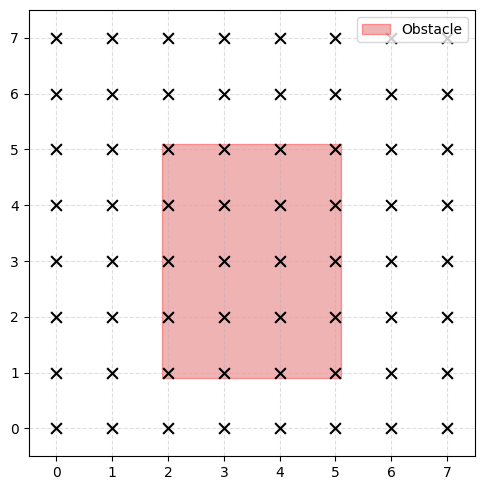

In [46]:
import matplotlib.patches as patches


def plot_2d_grid_with_obstacle(
    Lx=4, Ly=4, obs_x_start=x_low, obs_x_end=x_high, obs_y_start=y_low, obs_y_end=y_high
):
    """
    Plot a 2D lattice with a rectangular obstacle.

    Parameters
    ----------
    Lx, Ly : int
        Number of lattice sites in x and y directions.
    obs_x_start, obs_x_end : int
        Left and right faces (inclusive) of the obstacle region in x.
    obs_y_start, obs_y_end : int
        Bottom and top faces (inclusive) of the obstacle region in y.
    """
    # Basic sanity
    assert 0 <= obs_x_start <= obs_x_end < Lx, "Obstacle x must be within [0, Lx-1]."
    assert 0 <= obs_y_start <= obs_y_end < Ly, "Obstacle y must be within [0, Ly-1]."

    # Generate grid coordinates
    x_sites, y_sites = np.meshgrid(np.arange(Lx), np.arange(Ly))

    fig, ax = plt.subplots(figsize=(5, 5))

    # Draw lattice sites
    ax.scatter(x_sites, y_sites, marker="x", s=60, zorder=3, color="k")

    # Draw obstacle as shaded rectangle
    rect = patches.Rectangle(
        (obs_x_start - 0.1, obs_y_start - 0.1),
        obs_x_end - obs_x_start + 0.2,
        obs_y_end - obs_y_start + 0.2,
        linewidth=1,
        edgecolor="r",
        facecolor="tab:red",
        alpha=0.35,
        label="Obstacle",
    )
    ax.add_patch(rect)

    # Cosmetics
    ax.set_xlim(-0.5, Lx - 0.5)
    ax.set_ylim(-0.5, Ly - 0.5)
    ax.set_xticks(np.arange(Lx))
    ax.set_yticks(np.arange(Ly))
    ax.set_aspect("equal")
    ax.grid(True, which="both", linestyle="--", alpha=0.4)
    ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


# Example usage: 4x4 grid, obstacle at x=2, y=1..2
plot_2d_grid_with_obstacle(
    Lx=8, Ly=8, obs_x_start=x_low, obs_x_end=x_high, obs_y_start=y_low, obs_y_end=y_high
)

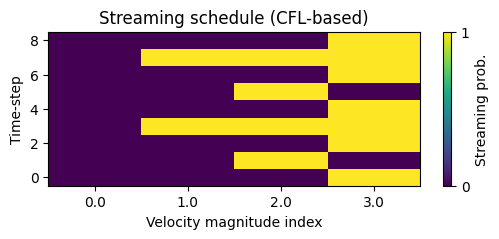

In [47]:
# Visualize which |u| move on each step
plt.figure(figsize=(6, 2))
plt.imshow(
    (pd.Series(schedule).apply(lambda s: np.isin(range(n_u_i), s)).tolist()),
    aspect="auto",
)
plt.xticks(range(len(u)), u)  # place ticks at 0..N-1, label them with magnitudes
plt.xlabel("Velocity magnitude index")
plt.ylabel("Time-step")
plt.title("Streaming schedule (CFL-based)")
plt.gca().invert_yaxis()

cbar = plt.colorbar(label="Streaming prob.")
cbar.set_ticks([0, 1])
plt.show()

The schedule dictates which velocity magnitudes are propagated at each time step. The time duration of sub-steps is chosen so that distributions do not propagate beyond the neighboring cell per sub-step. This prevents overshoot and reproduces integer grid walks.

## Streaming operator
The streaming operation receives the `schedule`, containing the streamed velocities at each time step. Conditioned on whether the velocity magnitude appears in `schedule[t]`, a sequential modular addition operation is performed on the associated grid variable $ \ket{\mathbf{x}}\ket{\mathbf{v}} \mapsto \ket{\mathbf{x}+\Delta \mathbf{x}}$. Finally, the ancilla and velocity registers are restored to their initial state. The operation manifests a conditional translation of a specific set of positional states.

In [48]:
## Stream operator


@qfunc
def stream(qs: PhaseSpaceStruct, indx: int) -> None:
    control(
        qs.u_x == indx,
        lambda: control(
            qs.v_dir_x,
            lambda: inplace_add(1, qs.g_x),
            lambda: inplace_add(-1, qs.g_x),
        ),
    )
    control(
        qs.u_y == indx,
        lambda: control(
            qs.v_dir_y,
            lambda: inplace_add(1, qs.g_y),
            lambda: inplace_add(-1, qs.g_y),
        ),
    )

Implementation of the streaming operator in Classiq

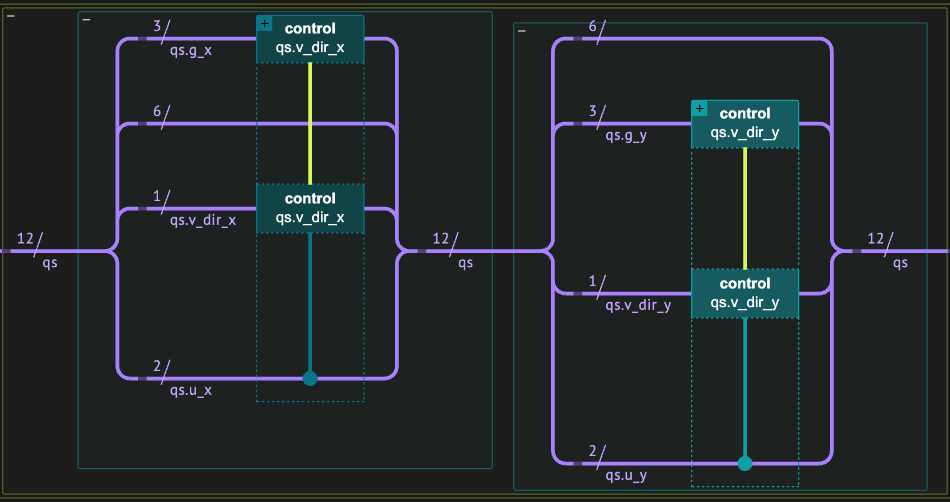

## Specular Reflection
The boundary reflection operation effectively reflects particles that enter the boundaries.
The boundary surfaces are assumed to be orthogonal to the lattice sites, and located right between two lattice sites. Each boundary surface is characterized by the lattice site inside the boundary closest to its surface, `position`, and the direction normal to the surface, `direction`.

Two types of reflections can occur:
(i) reflections from the corners of the reflecting object, and
(ii) reflections from the bulk of its surface.

(i) For particles colliding with a corner, the velocity components along both the $x$ and $y$ axes are reversed.

(ii) For particles colliding with the flat surface, only the velocity component normal to the surface is reversed, while the tangential component remains unchanged. 

Such a reflection scheme enables modeling the reflection process with a constant number of ancilla qubits.
This is achieved by ensuring that particles incident from different directions never scatter into the same outgoing direction.
Allowing multiple distinct incoming states to map onto a single outgoing state would correspond to a non-invertible transformation, thereby violating the unitarity condition required by the quantum circuit computation model.

A reflection operation is performed unitarily by a series of controlled operations, effectively reversing the appropriate velocity and placing the particles outside the boundaries in the appropriate lattice site:

1. For particles (distributions) reaching sites within the boundaries, flag an ancilla register.
2. For flagged particles, flip the velocity direction qubit and shift the particles according to the normal direction
3. For the translated particles, conditioned on the velocity normal to the surface and position, reset the ancilla register



Schematic representation of the two kinds of reflections — 
            corner reflections (top-left) and surface reflections (bottom and side surfaces):

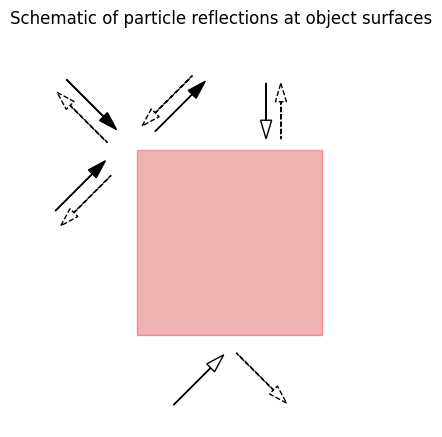

In [49]:
import math

import matplotlib.pyplot as plt

# === Create the figure and axis ===
fig, ax = plt.subplots()

# === Draw the reflecting object (red square) ===
# The square is centered in the figure with semi-transparent red fill
square = plt.Rectangle(
    (0.25, 0.25), 0.5, 0.5, linewidth=1, edgecolor="r", facecolor="tab:red", alpha=0.35
)
ax.add_patch(square)

# === Add first arrow pair (top-left corner reflection) ===
# Solid arrow: incoming direction (up-right)
arrow_start = (0.3, 0.8)
arrow_dx, arrow_dy = (0.1, 0.1)
ax.arrow(
    arrow_start[0],
    arrow_start[1],
    arrow_dx,
    arrow_dy,
    head_width=0.03,
    head_length=0.05,
    fc="black",
    ec="black",
)

# Dashed arrow: reflected direction (down-left)
arrow2_start = (arrow_start[0] + arrow_dx, arrow_start[1] + arrow_dy + 0.05)
arrow2_dx, arrow2_dy = (-0.1, -0.1)
ax.arrow(
    arrow2_start[0],
    arrow2_start[1],
    arrow2_dx,
    arrow2_dy,
    head_width=0.03,
    head_length=0.05,
    fc="none",
    ec="black",
    linestyle="--",
)

# === Add second arrow pair (upper-left side) ===
# Solid arrow: incident from top-left toward the object
arrow3_end = (0.16, 0.84)
arrow3_start = (arrow3_end[0] - 0.1, arrow3_end[1] + 0.1)
arrow3_dx = arrow3_end[0] - arrow3_start[0]
arrow3_dy = arrow3_end[1] - arrow3_start[1]
ax.arrow(
    arrow3_start[0],
    arrow3_start[1],
    arrow3_dx,
    arrow3_dy,
    head_width=0.03,
    head_length=0.05,
    fc="black",
    ec="black",
)

# Dashed arrow: reflection opposite to incident direction
arrow4_start = (arrow3_start[0] + arrow3_dx + 0.01, arrow3_start[1] + arrow3_dy - 0.07)
arrow4_dx, arrow4_dy = (-0.1, 0.1)
ax.arrow(
    arrow4_start[0],
    arrow4_start[1],
    arrow4_dx,
    arrow4_dy,
    head_width=0.03,
    head_length=0.05,
    fc="none",
    ec="black",
    linestyle="--",
)

# === Define helper for rotation (used below) ===
angle_rad = math.radians(90)


def rotate(dx, dy):
    """Rotate a vector (dx, dy) 90 degrees counterclockwise."""
    new_dx = dx * math.cos(angle_rad) - dy * math.sin(angle_rad)
    new_dy = dx * math.sin(angle_rad) + dy * math.cos(angle_rad)
    return new_dx, new_dy


# === Add third arrow pair (lower-left side, rotated 90° CCW) ===
arrow5_end = (0.16, 0.64)
arrow5_start = (arrow5_end[0] - 0.1, arrow5_end[1] + 0.1)
arrow5_dx, arrow5_dy = rotate(
    arrow5_end[0] - arrow5_start[0], arrow5_end[1] - arrow5_start[1]
)

# Solid arrow: incident direction
ax.arrow(
    arrow5_start[0] - 0.03,
    arrow5_start[1] - 0.155,
    arrow5_dx,
    arrow5_dy,
    head_width=0.03,
    head_length=0.05,
    fc="black",
    ec="black",
)

# Dashed arrow: reflection (opposite)
arrow6_start = (arrow5_start[0] + arrow5_dx + 0.02, arrow5_start[1] + arrow5_dy - 0.06)
arrow6_dx, arrow6_dy = rotate(-0.1, 0.1)
ax.arrow(
    arrow6_start[0],
    arrow6_start[1] - 0.1,
    arrow6_dx,
    arrow6_dy,
    head_width=0.03,
    head_length=0.05,
    fc="none",
    ec="black",
    linestyle="--",
)

# === Add pair of arrows to bottom surface (center reflection) ===
# Solid arrow: incoming (upward)
arrow7_start = (0.35, 0.06)
arrow7_dx, arrow7_dy = (0.1, 0.1)
ax.arrow(
    arrow7_start[0],
    arrow7_start[1],
    arrow7_dx,
    arrow7_dy,
    head_width=0.03,
    head_length=0.05,
    fc="none",
    ec="black",
)

# Dashed arrow: reflected (downward)
arrow8_start = (0.52, 0.2)
arrow8_dx, arrow8_dy = (0.1, -0.1)
ax.arrow(
    arrow8_start[0],
    arrow8_start[1],
    arrow8_dx,
    arrow8_dy,
    head_width=0.03,
    head_length=0.05,
    fc="none",
    ec="black",
    linestyle="--",
)

# === Add final vertical pair (top reflection) ===
# Solid: downward arrow from top
arrow9_start = (0.6, 0.93)
arrow9_dx, arrow9_dy = (0, -0.1)
ax.arrow(
    arrow9_start[0],
    arrow9_start[1],
    arrow9_dx,
    arrow9_dy,
    head_width=0.03,
    head_length=0.05,
    fc="none",
    ec="black",
)

# Dashed: reflected upward
arrow10_start = (0.64, 0.78)
arrow10_dx, arrow10_dy = (0, 0.1)
ax.arrow(
    arrow10_start[0],
    arrow10_start[1],
    arrow10_dx,
    arrow10_dy,
    head_width=0.03,
    head_length=0.05,
    fc="none",
    ec="black",
    linestyle="--",
)

# === Final plot settings ===
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect("equal")

# Remove all tick marks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

fig.suptitle("Schematic of particle reflections at object surfaces")

# Optionally remove axis spines for a cleaner figure
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

In [50]:
@qfunc
def flip_velocity(
    change_pos: QNum,
    fixed_pos: QNum,
    change_u: QNum,
    change_v_dir: QBit,
    mag: int,
    arr: CArray[CReal],
) -> None:
    """flips the velocity of a certain direction "change" for particles in a regime defined by array arr."""
    change_low, change_high, fixed_low, fixed_high = arr[0], arr[1], arr[2], arr[3]
    # if the particle entered the object and is on the lattice points closest the surface, flip the associated velocity
    control(
        ((change_pos == change_low) | (change_pos == change_high))
        & (fixed_pos >= fixed_low)
        & (fixed_pos <= fixed_high)
        & (change_u == mag),
        lambda: X(change_v_dir),
    )


@qfunc
def reflection(qs: PhaseSpaceStruct, mag: int, limits: CArray[CReal]) -> None:
    """
    Performs a reflection of the particles reaching lattice sites on the boundary
    Note that such a reflection limits the initial conditions.

    Parameters:
        reg:  PhaseSpaceStruct, the complete register of the system
        mag: int, velocity magnitude
        limits: list (of QArray[CInt]), defines the limits of the reflecting object
    """

    x_low, x_high, y_low, y_high = limits[0], limits[1], limits[2], limits[3]
    # reverse the velocity

    # from the top and bottom of the object
    top_bottom_arr = [y_low, y_high, x_low, x_high]
    flip_velocity(
        change_pos=qs.g_y,
        fixed_pos=qs.g_x,
        change_u=qs.u_y,
        change_v_dir=qs.v_dir_y,
        mag=mag,
        arr=top_bottom_arr,
    )
    # from the left and right of the object
    flip_velocity(
        change_pos=qs.g_x,
        fixed_pos=qs.g_y,
        change_u=qs.u_x,
        change_v_dir=qs.v_dir_x,
        mag=mag,
        arr=limits,
    )

Implementation of the reflection operator within the main quantum circuit:

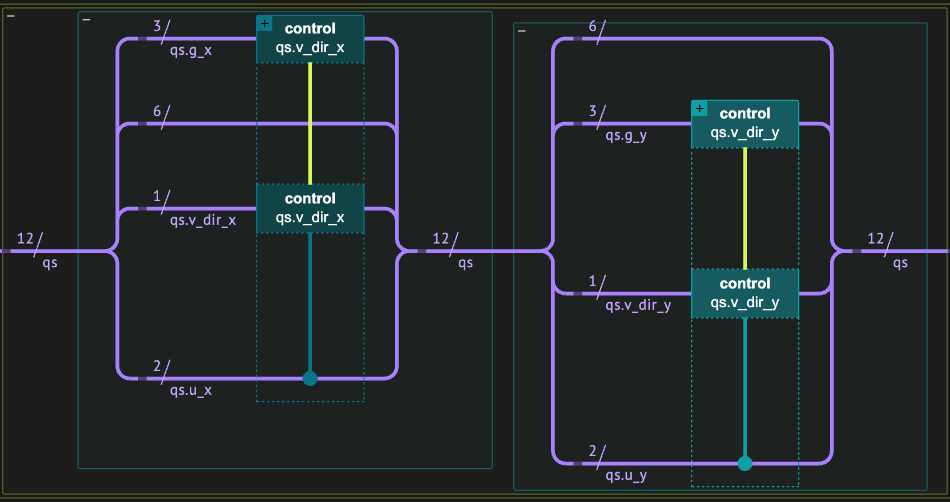

## Build the quantum program

In [51]:
@qfunc
def main(qs: Output[PhaseSpaceStruct]) -> None:
    allocate(qs)

    # Prepare the initial register
    init_state2D(qs, g_dist_x, g_dist_y, u_dist)

    # Number of time steps
    Nt = len(schedule)

    # Iterate over time steps
    for t in range(Nt):
        # Iterate over magnitudes to stream
        for mag in schedule[t]:
            # Stream
            stream(qs, mag)

            # Reflect from boundaries
            reflection(qs, mag, limits)


write_qmod(main, "qlbm", symbolic_only=False)
qprog = synthesize(main)
job = execute(qprog)

## Execution and results

We run the quantum program on a statevector simulator to retrieve the full solution.

In [52]:
with ExecutionSession(qprog) as es:
    results = es.sample()
table = results.dataframe.to_numpy()

Taking a look at a small part of the results

In [53]:
results.dataframe.head()

,qs.g_x,qs.g_y,qs.v_dir_x,qs.v_dir_y,qs.u_x,qs.u_y,count,probability,bitstring
0,6,4,1,1,3,1,88,0.042969,011111100110
1,1,2,0,1,1,0,79,0.038574,000110010001
2,1,4,0,0,1,2,78,0.038086,100100100001
3,7,4,0,1,2,1,77,0.037598,011010100111
4,6,4,1,1,3,2,76,0.037109,101111100110


Evaluating the spatial and velocity magnitude distribution, $p(x)$ and $p(u)$.

In [54]:
def get_p(dataframe, jx, jy, n):
    """
    Extracts a 2D probability map from the dataframe
    where columns jx and jy correspond to the x and y indices.

    Parameters:
        dataframe: pandas.DataFrame, the table containing measurement results.
        jx, jy: int, column indices for the x and y registers.
        n: int, number of discrete x and y states (assumes square grid n x n).

    Returns:
        p: np.ndarray, 2D array of summed probabilities p[x, y].
    """
    p = np.zeros((n, n))
    for x in range(n):
        for y in range(n):
            # mask the case of interest
            mask = (dataframe.iloc[:, jx] == x) & (dataframe.iloc[:, jy] == y)
            p[y, x] = np.sum(dataframe.loc[mask].to_numpy()[:, 7])
    return p


# 2D distribution
p_xy = get_p(results.dataframe, jx=0, jy=1, n=n_g_i)
p_u_xy = get_p(results.dataframe, jx=4, jy=5, n=n_u_i)

### Plots

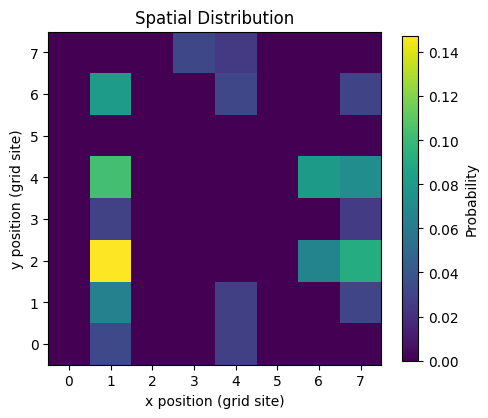

In [55]:
plt.figure(figsize=(5, 5))
plt.imshow(
    p_xy,
    cmap="viridis",
    origin="lower",  # make (0,0) appear bottom-left
    aspect="equal",
)

# Add colorbar
plt.colorbar(label="Probability", shrink=0.7)

# Label axes
plt.xlabel("x position (grid site)")
plt.ylabel("y position (grid site)")

# Set tick positions and labels
plt.xticks(range(p_xy.shape[1]), range(p_xy.shape[1]))
plt.yticks(range(p_xy.shape[0]), range(p_xy.shape[0]))

plt.title("Spatial Distribution")
plt.tight_layout()
plt.show()

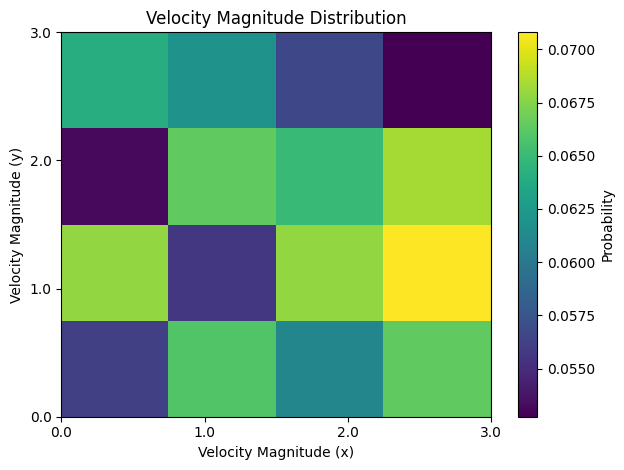

In [56]:
# Map pixels to real x/y coordinates
plt.imshow(
    p_u_xy,
    cmap="viridis",
    aspect="auto",
    origin="lower",
    extent=[u[0], u[-1], u[0], u[-1]],  # x_min, x_max, y_min, y_max
)

plt.colorbar(label="Probability")

# Tick marks exactly at your u values
plt.xticks(u, [f"{val:.1f}" for val in u])
plt.yticks(u, [f"{val:.1f}" for val in u])

plt.title("Velocity Magnitude Distribution")
plt.xlabel("Velocity Magnitude (x)")
plt.ylabel("Velocity Magnitude (y)")
plt.tight_layout()
plt.show()

## Analysis 

The simulation starts with particles placed at lattice site $(x_0, y_0) = (1,2)$, and their velocities are distributed uniformly — meaning each possible speed is equally likely at the beginning. We apply periodic boundary conditions, so particles that leave the domain on one side re-enter from the other. In addition, a reflecting obstacle is a rectangle with the corners situated at $(2,1)$, $(2,5)$, $(5,1)$, and $(5,5)$.

As the system evolves, particles outside the obstacle move freely, while those reaching the obstacle bounce back. After several time steps, the particles cover the free space surrounding the reflecting object. 


The velocity-magnitude plot shows that all speeds still have roughly the same probability. This makes sense because no collisions occur in this setup, so the distribution of speeds doesn’t change over time, only the direction of the velocities. The small differences between probabilities come only from statistical fluctuations, since we are working with a finite number of samples from the quantum simulation.

## Technical Background


### Classical methods

The dynamics of fluids with low compressibility and  isothermal conditions are described by the small Mach number limit of the Navier--Stokes equations:
$$\frac{\partial\rho}{\partial t} + \nabla \cdot \rho\mathbf{u} = 0~~,~~\text{(Continuity eq.)}$$
$$\rho
\left(
\frac{\partial \mathbf{u}}{\partial t} 
+ \mathbf{u} \cdot \nabla \mathbf{u}
\right)
= 
-\nabla p 
+ \mu \nabla^2 \mathbf{u} 
+ \rho \mathbf{F}~~,~~ \text{(Momentum eq.)}$$
where $\mathbf{u}$ is the velocity field, $\rho$ is the fluid density, 
$p$ is the hydrodynamic pressure, $\mu$ is the dynamic viscosity, 
and $\mathbf{F}$ represents external body forces.


The nonlinear and multiscale nature of these equations imposes significant computational demands on classical solvers. For standard discretization-based approaches, the per-time-step computational complexity scales as $O(N_x^d)$ where $N_x$ is the number of grid points per spatial dimension and $d$ is the dimensionality of the system. However, resolving all relevant turbulent scales requires a grid resolution that scales unfavorably with the Reynolds number, approximately as, $Re^{9/4}$. Consequently, the total computational cost of direct numerical simulation (DNS) grows effectively exponentially with $Re$. Moreover, classical Navier–Stokes solvers are difficult to parallelize efficiently because enforcing incompressibility introduces global dependencies that prevent fully local computation. 

### Kinetic Formulation
An alternative, microscopic viewpoint is provided by the Boltzmann transport equation:
$$    \frac{\partial f}{\partial t} + \mathbf{v}
    \cdot \nabla f + \mathbf{F}\cdot\frac{\partial f}{\partial \mathbf p} = Q(f,f)~~,$$
where $f(\mathbf{x}, \mathbf{v}, t)$ is the single-particle distribution function over phase space, 
$\mathbf{F}$ represents external forces, and $Q(f,f)$ is the collision operator describing molecular interactions. 
The collision term involves a high-dimensional integral over all pre- and post-collision velocities and scattering angles, 
making its evaluation the dominant computational cost. 
For deterministic discretizations, the complexity per time step scales as
$$O(N_x^d N_v^{2d})~~,$$
where $N_v$ is the number of discrete velocity points per dimension. 

### BGK Approximation

A major simplification is obtained by replacing the collision operator with a local relaxation term toward equilibrium:
$$\frac{\partial f}{\partial t}
+ \mathbf{v} \cdot \nabla f
+ \mathbf{F} \cdot \frac{\partial f}{\mathbf{\partial p}}
= -\Gamma (f - f^{\text{eq}})~~,
\tag{1}
$$
where $\Gamma$ is the relaxation rate and $f^{\text{eq}}$ is the local Maxwellian equilibrium distribution. 
This Bhatnagar--Gross--Krook (BGK) approximation replaces the complex integral operator with a local operation that depends only on a few velocity moments. 
Despite this simplification, direct numerical integration of Eq.~(1) still requires evolving $f(\mathbf{x}, \mathbf{v}, t)$ across both position and velocity grids, leading to a per-time-step complexity of
$$O(N_x^d N_v^d)~~. $$

### Lattice Boltzmann Method (LBM)
The (LBM) offers an efficient and scalable alternative. 
LBM discretizes velocity space into a small set of representative directions, allowing collisions and streaming to be computed locally in time and space. 
This locality enables excellent parallelization and simplifies the handling of complex geometries and boundary conditions. 
The resulting per-time-step complexity scales as
$$O(N_x^d V^d)~~,$$
where $V$ is the number of discrete velocity directions per dimension (typically small and fixed). 



## References

[1] [Schalkers, M.A. & Möller. Efficient and fail-safe quantum algorithm for the transport equation. M., Journal of Computational Physics, 502, p.112816](https://www.sciencedirect.com/science/article/pii/S0021999124000652?ref=pdf_download&fr=RR-2&rr=984897380e483d7c) 

[2] [Budinski, L.. Quantum algorithm for the advection–diffusion equation simulated with the lattice Boltzmann method. Quantum Information Processing, 20(2), 57.](https://link.springer.com/article/10.1007/s11128-021-02996-3)

[3] [Todorova, B. N., & Steijl, R. (2020). Quantum algorithm for the collisionless Boltzmann equation. Journal of Computational Physics, 409, 109347](https://www.sciencedirect.com/science/article/abs/pii/S0021999120301212)